In [4]:
import dask.array as da
import dask.dataframe as dd
import numpy as np
import pandas as pd
import pandera as pa
import ray
from boost.numerical.activation_functions import ActivationFunction
from ray.util.dask import disable_dask_on_ray, enable_dask_on_ray, ray_dask_get
from sklearn.linear_model import BayesianRidge

In [5]:
def generate_synthetic_data(start_date, n_samples=1000, freq="min"):
    """
    Generate synthetic financial data with columns 'open', 'low', 'high', 'close', and 'volume'.

    Parameters:
    - start_date (str): The start date of the data in 'YYYY-MM-DD' format.
    - n_samples (int): Number of data points to generate. Default is 1000.
    - freq (str): Frequency of the data. Default is 'T' for minute frequency.

    Returns:
    - DataFrame: A pandas DataFrame containing the synthetic financial data.
    """
    # Generate a range of datetime values based on the number of samples
    start_datetime = pd.to_datetime(start_date)
    end_datetime = start_datetime + pd.Timedelta(
        minutes=n_samples
    )  # End date based on number of samples and frequency
    date_range = pd.date_range(
        start=start_datetime, end=end_datetime, freq=freq
    )[:n_samples]

    # Initialize empty lists for the columns
    open_prices = []
    low_prices = []
    high_prices = []
    close_prices = []
    volumes = []

    # Generate synthetic data
    for i in range(n_samples):
        open_price = np.random.uniform(450, 500)
        high_price = open_price + np.random.uniform(0, 2)
        low_price = open_price - np.random.uniform(0, 2)
        close_price = np.random.uniform(low_price, high_price)
        volume = np.random.randint(100000, 1000000)

        open_prices.append(open_price)
        low_prices.append(low_price)
        high_prices.append(high_price)
        close_prices.append(close_price)
        volumes.append(volume)

    # Create a DataFrame
    df = dd.DataFrame.from_dict(
        {
            "datetime": date_range,
            "open": open_prices,
            "low": low_prices,
            "high": high_prices,
            "close": close_prices,
            "volume": volumes,
        },
        npartitions=100,
    )

    # Set 'datetime' as the index
    df = df.set_index("datetime")

    return df

In [6]:
def generate_basis(
    time_step: float,
    num_samples: int,
    num_basis_functions: int,
    activation_function: ActivationFunction,
):
    """
    Generate a basis matrix using a specified activation function.

    Parameters:
    -----------
    time_step : float
        The step size or spacing between basis functions.
    num_samples : int
        The number of sample points or data points.
    num_basis_functions : int
        The number of basis functions to generate.
    activation_function : Callable[[da.Array], da.Array]
        A callable activation function that takes a Dask array as input
        and returns a Dask array. The function should apply an
        element-wise activation, such as ReLU.

    Returns:
    --------
    da.Array
        A Dask array of shape (num_samples, num_basis_functions) where
        each column is the result of applying the activation function
        to the sample indices shifted by the corresponding basis
        function shift.

    Example:
    --------
    >>> import dask.array as da
    >>> basis = generate_basis(
        time_step=0.5,
        num_samples=10,
        num_basis_functions=3,
        activation_function=ActivationFunction.hard_swish,
    )
    >>> basis.compute()
    array([[ 0.        , -0.20833333, -0.33333333],
           [ 0.66666667,  0.29166667,  0.        ],
           [ 1.66666667,  1.125     ,  0.66666667],
           [ 3.        ,  2.29166667,  1.66666667],
           [ 4.        ,  3.5       ,  3.        ],
           [ 5.        ,  4.5       ,  4.        ],
           [ 6.        ,  5.5       ,  5.        ],
           [ 7.        ,  6.5       ,  6.        ],
           [ 8.        ,  7.5       ,  7.        ],
           [ 9.        ,  8.5       ,  8.        ]])
    """
    sample_indices = da.arange(num_samples)
    time_offsets = da.arange(num_basis_functions) * time_step
    return activation_function(sample_indices[:, None] - time_offsets)


def normalize_basis(basis: da.Array):
    covariance_matrix = da.cov(basis, rowvar=False)

    num_samples = basis.shape[0]

    U, S, V = da.linalg.svd_compressed(
        a=covariance_matrix,
        k=num_samples,
    )

    # Normalize the basis matrix
    normalized_basis = da.dot(basis, U) / np.sqrt(S)

    return normalized_basis


def calculate_delta_df(
    series: dd.Series,
    num_samples: int,
) -> dd.DataFrame:
    delta_series = series - series.shift(1)

    # NOTE: This operation intentionally introduces data leakage
    delta_series = delta_series.bfill().fillna(0)

    delta_series = delta_series.rename(f"{series.name}:delta=1")

    delta_df = delta_series.to_frame()

    delta_df = delta_df.reset_index()

    delta_df["time"] = delta_df["datetime"].dt.time

    delta_df = delta_df.set_index("datetime")

    delta_df["numerical_index"] = pd.Series(
        np.arange(
            start=0,
            stop=len(delta_df),
        ),
        index=delta_df.index,
    )

    selected_days = delta_df.index.where(
        delta_df["numerical_index"] % num_samples == 0,
    ).dropna()

    delta_df["temp:delta_adjustment"] = delta_df["close:delta=1"].cumsum()[
        selected_days
    ]

    delta_df["temp:delta_adjustment"] = (
        delta_df["temp:delta_adjustment"].repartition(npartitions=1).ffill()
    )

    delta_df["close:delta=1:cumsum_adjusted"] = (
        delta_df["close:delta=1"].cumsum() - delta_df["temp:delta_adjustment"]
    )

    delta_df = delta_df.drop(columns=["temp:delta_adjustment"])

    return delta_df


def generate_weights(target_series, num_samples, basis):
    @ray.remote
    def _train(basis, arr):
        bayesian_ridge_model.fit(basis, arr)
        return np.around(bayesian_ridge_model.coef_, 6)

    target_length = len(target_series)

    target = target_series.to_dask_array(lengths=True)

    target_trimmed = target[-((target_length // num_samples) * num_samples) :]

    sliced = da.lib.stride_tricks.sliding_window_view(
        target_trimmed, num_samples
    )[::num_samples, :]

    bayesian_ridge_model = BayesianRidge(fit_intercept=False)

    return np.vstack(ray.get([_train.remote(basis, arr) for arr in sliced]))

In [7]:
close_prices_schema = pa.SeriesSchema(
    float,
    nullable=False,
    unique=False,
)

delta_schema = pa.DataFrameSchema(
    {
        # Match any default column name
        ".*:delta=\d.*": pa.Column(
            np.float64,
            nullable=False,
            regex=True,
        ),
        "time": pa.Column(
            str,
            nullable=False,
        ),
        "numerical_index": pa.Column(
            np.int64,
            nullable=False,
        ),
    }
)

In [10]:
num_samples = 36
num_basis_functions = 9
time_step: float = num_samples / num_basis_functions

basis = generate_basis(
    time_step=time_step,
    num_samples=num_samples,
    num_basis_functions=num_basis_functions,
    activation_function=ActivationFunction.relu,
)

print(basis)

normalized_basis = normalize_basis(basis=basis)

# close_prices = generate_synthetic_data(
#     start_date="2000-01-01",
#     n_samples=1000,
# )["close"]

# close_prices_df_validated = close_prices_schema.validate(close_prices)
# close_prices_delta_df = calculate_delta_df(
#     close_prices_df_validated,
#     num_samples=num_samples,
# )

# close_prices_delta_df_validated = delta_schema.validate(close_prices_delta_df)

# weights = generate_weights(
#     target_series=close_prices_delta_df_validated[
#         "close:delta=1:cumsum_adjusted"
#     ],
#     num_samples=num_samples,
#     basis=normalized_basis,
# )

dask.array<maximum, shape=(36, 9), dtype=float64, chunksize=(36, 9), chunktype=numpy.ndarray>


<Axes: >

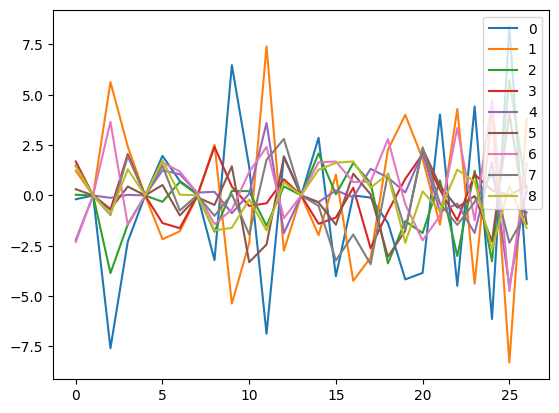

In [ ]:
pd.DataFrame(weights).plot()